In [31]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline


In [32]:
roads = pd.read_csv('./data/road.csv')
fill_data_basic = roads[roads['highway'].isna()]
full_data_basic = roads[~roads['highway'].isna()]


In [33]:
with open('./data/road_neighbor_cd.json') as f:
    data = json.load(f)

fill_data_adjcent = {}
full_data_adjacent = {}
for key, value in data.items():
    key = int(key)
    if key in full_data_basic['id']:
        full_data_adjacent[key] = value
    else:
        fill_data_adjcent[key] = value


In [34]:
adj_map = {}
for key, values in full_data_adjacent.items():
    highway_type =  full_data_basic.loc[full_data_basic['id'] == key, 'highway'].values[0]
    value_list = []
    temp_map = {}
    for value in values:
        if value in full_data_basic['id'].values:
            value_list.append(full_data_basic.loc[full_data_basic['id'] == value, 'highway'].values[0])
    for value in value_list:
        temp_map[value] = temp_map.get(value, 0) + 1
    
    for key2, value2 in temp_map.items():
        if key2 not in adj_map:
            adj_map[key2] = {}
        adj_map[key2][highway_type] = adj_map[key2].get(highway_type, 0) + value2
sorted_map = {k: dict(sorted(v.items())) for k, v in sorted(adj_map.items())}


In [35]:
for key, value in sorted_map.items():
    list_of_values = []
    for key2, value2 in value.items():
        list_of_values.append(value2)
    for key2, value2 in value.items():
        value[key2] = value2 / sum(list_of_values) * 100
print(sorted_map)

{0.0: {1.0: 100.0}, 1.0: {1.0: 68.04123711340206, 2.0: 4.123711340206185, 3.0: 1.0309278350515463, 5.0: 2.0618556701030926, 8.0: 22.68041237113402, 9.0: 2.0618556701030926}, 2.0: {1.0: 0.5692599620493358, 2.0: 56.92599620493358, 3.0: 9.392789373814042, 4.0: 14.61100569259962, 5.0: 5.88235294117647, 6.0: 9.297912713472485, 8.0: 0.9487666034155597, 9.0: 1.3282732447817838, 10.0: 0.09487666034155598, 12.0: 0.9487666034155597}, 3.0: {1.0: 0.1551590380139643, 2.0: 7.757951900698215, 3.0: 58.41737781225756, 4.0: 12.95577967416602, 5.0: 4.654771140418929, 6.0: 12.95577967416602, 8.0: 0.7757951900698216, 9.0: 0.6206361520558572, 10.0: 1.2412723041117144, 11.0: 0.07757951900698215, 12.0: 0.3878975950349108}, 4.0: {1.0: 0.033355570380253496, 2.0: 4.903268845897265, 3.0: 5.303535690460307, 4.0: 74.11607738492329, 5.0: 3.502334889926618, 6.0: 10.940627084723149, 8.0: 0.033355570380253496, 9.0: 0.23348899266177453, 10.0: 0.06671114076050699, 11.0: 0.06671114076050699, 12.0: 0.8005336891260841}, 5.0

c:\Users\86138\anaconda3\envs\dataMining\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\86138\anaconda3\envs\dataMining\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


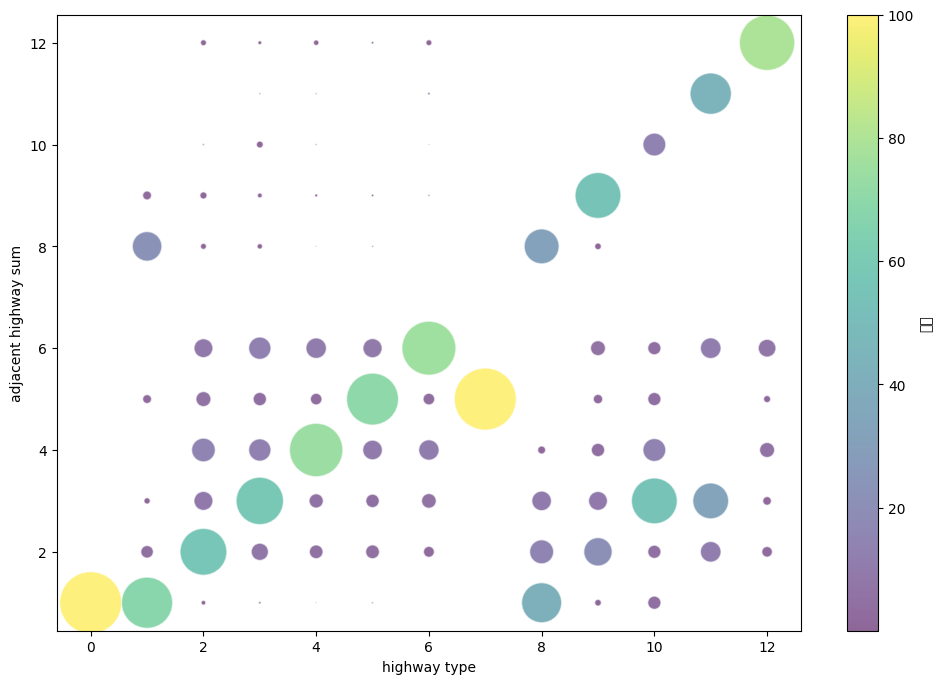

In [36]:
plt.figure(figsize=(12, 8))

# 用于保存可视化的值
x = []
y = []
sizes = []

# 遍历排序后的字典并准备数据
for key, sub_dict in sorted_map.items():
    for sub_key, count in sub_dict.items():
        x.append(key)
        y.append(sub_key)
        sizes.append(count)  # 可以用 count 来决定点的大小

# 使用散点图进行可视化，点的大小与数量成比例
plt.scatter(x, y, s=np.array(sizes)*20, c=sizes, cmap='viridis', alpha=0.6, edgecolors='w')

# 添加标签和标题
plt.xlabel('highway type')
plt.ylabel('adjacent highway sum')

# 显示颜色条
plt.colorbar(label='数量')

# 显示图形
plt.show()

In [37]:
for key, values in fill_data_adjcent.items():
    value_list = []
    for value in values:
        if value in full_data_basic['id'].values:
            value_list.append(full_data_basic.loc[full_data_basic['id'] == value, 'highway'].values[0])
    print(key, value_list)

8 [3.0]
14 [6.0, 6.0, 5.0]
15 [5.0, 2.0, 5.0]
17 [3.0]
19 [6.0]
23 [3.0]
29 [5.0]
31 [2.0]
33 []
37 [8.0, 1.0]
44 [1.0]
45 [2.0]
50 [5.0]
57 [3.0, 2.0]
63 [3.0, 6.0]
65 [4.0, 4.0, 3.0]
69 [6.0, 6.0, 5.0]
79 [6.0, 6.0, 6.0]
80 [4.0, 3.0]
84 [2.0]
88 [2.0]
90 []
93 [3.0]
101 [2.0, 9.0]
102 []
106 [4.0, 2.0]
107 [7.0, 5.0]
110 [4.0, 4.0]
121 [3.0]
124 [4.0]
132 [6.0, 4.0, 6.0]
135 [12.0]
142 [3.0, 2.0]
144 [2.0, 6.0]
149 [8.0]
151 [1.0]
156 [4.0, 6.0, 4.0]
157 [2.0, 4.0, 4.0]
167 [2.0, 2.0]
168 [2.0]
177 [6.0, 6.0, 5.0]
179 [6.0, 6.0]
181 [2.0, 3.0]
185 [5.0]
196 [2.0, 3.0]
198 [4.0, 2.0]
199 [4.0, 4.0, 4.0]
208 [5.0, 3.0, 10.0]
217 [4.0, 4.0, 3.0]
221 [3.0, 3.0]
227 [1.0]
228 [2.0, 11.0]
230 []
233 [3.0, 3.0]
239 [3.0]
240 [6.0, 6.0, 3.0]
245 [3.0]
247 [6.0, 6.0]
248 [6.0, 6.0]
251 [3.0, 3.0, 2.0]
254 [4.0, 3.0, 4.0]
257 [4.0, 6.0, 4.0]
259 [2.0, 3.0]
263 [4.0, 4.0, 3.0]
272 [6.0]
279 [3.0, 3.0, 3.0]
286 []
290 [3.0]
292 [3.0, 6.0]
293 [6.0]
296 [2.0, 2.0, 6.0]
297 [3.0]
303 [3.0, 3.0, 3

In [84]:
def haversine_to_cartesian(lat, lon, ref_lat, ref_lon):
    # 地球半径(米)
    R = 6371.0 * 1000

    # 转换为弧度
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    ref_lat_rad = np.radians(ref_lat)
    ref_lon_rad = np.radians(ref_lon)

    # 计算经纬度差异
    dlat = lat_rad - ref_lat_rad
    dlon = lon_rad - ref_lon_rad

    # 计算平面坐标
    x = R * dlon * np.cos(ref_lat_rad)
    y = R * dlat

    return x, y

# 计算曲率
def curvature(x):
    f_prime = cs.derivative(1)(x)
    f_double_prime = cs.derivative(2)(x)
    return np.abs(f_double_prime) / (1 + f_prime**2)**(3/2)

In [85]:
test_id = 1
point_num = 2000

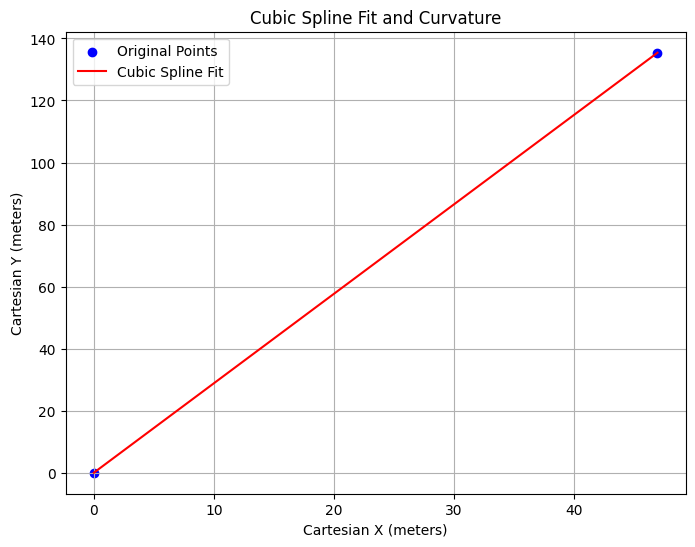

Average Curvature: 0.0


In [86]:
# 假设您已经从 DataFrame 中提取了坐标
test_points = eval(roads.loc[roads['id'] == test_id, 'coordinates'].values[0])

lat_coords = np.array([point[1] for point in test_points])  # 纬度在第二列
lon_coords = np.array([point[0] for point in test_points])  # 经度在第一列

# 以第一个点为参考系
ref_lat = lat_coords[0]
ref_lon = lon_coords[0]

# 转换为平面直角坐标
x_coords, y_coords = haversine_to_cartesian(lat_coords, lon_coords, ref_lat, ref_lon)

# 创建三次样条插值
cs = CubicSpline(x_coords, y_coords)

# 生成拟合曲线的 x 值
x_fit = np.linspace(min(x_coords), max(x_coords), point_num)
y_fit = cs(x_fit)

curvatures = curvature(x_fit)

plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, color='blue', marker='o', label='Original Points')

plt.plot(x_fit, y_fit, color='red', label='Cubic Spline Fit')

plt.title('Cubic Spline Fit and Curvature')
plt.xlabel('Cartesian X (meters)')
plt.ylabel('Cartesian Y (meters)')
plt.grid(True)
plt.legend()

plt.show()

average_curvature = np.mean(curvatures)
print('Average Curvature:', average_curvature)
